# Basic Kinematic Plots

In this section, we’ll examine **basic kinematic distributions** for our processes. Specifically, we’ll compare:

- **Signal process:** H → WW via gluon–gluon fusion  
- **Background processes:** The main contributors that can mimic the signal

These plots serve an important purpose: they help us **see how signal and background events differ**. Understanding these differences is key for identifying which variables are most useful when selecting events and performing analyses.

By studying these distributions, we get a clearer picture of the underlying physics, making it easier to design effective selection criteria and improve the sensitivity of our study.


### Verifying the Notebook Environment

Before starting the analysis, it’s a good idea to make sure our notebook is running smoothly. We do this by executing a simple test cell in Jupyter to confirm everything is working as expected.


In [1]:
print("Higgs")

Higgs


### Setting the Working Directory

To make our workflow easier, we set the working directory to the folder containing the input ROOT files. This way, we can reference file paths relative to this directory, avoiding long and error-prone absolute paths.


In [10]:
import os 
# Check the current directory
print("Current directory:", os.getcwd())

# Change to the folder containing NanoAOD ROOT files
os.chdir("C:\MAIN\HSF-India\H-WW-analysis\Root_files")

# Confirm the change
print("\nNew working directory:", os.getcwd())

print(os.listdir())  # List files in the current directory

Current directory: c:\MAIN\HSF-India\H-to-WW-NanoAOD-analysis\notebooks

New working directory: C:\MAIN\HSF-India\H-WW-analysis\Root_files
['.ipynb_checkpoints', 'analysis_summary.txt', 'Dy.root', 'Higgs.root', 'ST.root', 'superimposed.ipynb', 'super_imp.py', 'Test_Get_plot.html', 'Test_Get_plot.ipynb', 'ttbar.root', 'WW.root', 'WZ.root', 'ZZ.root']


<>:6: SyntaxWarning: invalid escape sequence '\M'
<>:6: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Anuj\AppData\Local\Temp\ipykernel_13620\2004383459.py:6: SyntaxWarning: invalid escape sequence '\M'
  os.chdir("C:\MAIN\HSF-India\H-WW-analysis\Root_files")


### Importing Required Libraries

The next step is we need to load the Python libraries that will make our work with NanoAOD data possible:

- `uproot` → Open and read ROOT files  
- `awkward` → Handle jagged arrays (event-based data)  
- `numpy` → Perform numerical computations efficiently  
- `matplotlib` → Create histograms and visualize distributions  
- `vector` → Work with four-vectors (momenta, invariant mass, ΔR, etc.)

In [11]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import vector

# Register vector support for awkward arrays
vector.register_awkward()

### Defining Input Datasets

Next, we set up a dictionary of input ROOT files for both **signal** and **background** processes.  
In this dictionary, each key is a short label, and each value points to the corresponding ROOT filename:

- **ggH** → Higgs boson signal (H → WW via gluon–gluon fusion)  
- **DY** → Drell–Yan background  
- **TT** → Top–antitop production  
- **WW**, **WZ**, **ZZ** → Diboson backgrounds  
- **St** → Single top background


In [37]:
files = {
    "signal": "Higgs.root",   # Signal
    "DY to Tau_Tau": "Dy.root",       # Drell-Yan background
    "TT": "ttbar.root",    # Top quark pair background
    "WW": "WW.root",       # Diboson background
    "WZ": "WZ.root",       # Diboson background
    "ZZ": "ZZ.root",       # Diboson background
    "St": "ST.root"        # Single top background
}

### Defining Plot Colors

To make our plots clear and easy to interpret, we assign a consistent color to each dataset. This way, signal and background distributions are visually distinct across all plots:

- **ggH (signal)** → red  
- **DY** → blue  
- **TT** → green  
- **WW** → orange  
- **WZ** → purple  
- **ZZ** → brown  
- **St** → cyan


In [38]:
colors = {
    "signal": "red",       # Signal
    "DY to Tau_Tau": "blue",       # Drell-Yan background
    "TT": "green",      # Top quark pair background
    "WW": "orange",     # Diboson background
    "WZ": "purple",     # Diboson background
    "ZZ": "brown",      # Diboson background
    "St": "cyan"        # Single top background
}

### Checking Available Datasets

Before moving forward, it’s a good idea to print the list of dataset labels. This helps us confirm that the input dictionary has been set up correctly and that all expected datasets are available for analysis.


In [39]:
print("Files to process:", list(files.keys()))

Files to process: ['signal', 'DY to Tau_Tau', 'TT', 'WW', 'WZ', 'ZZ', 'St']


### Event Selection: eμ Final State

We define a function `select_e_mu` to pick events that meet the following criteria:

- **Exactly 1 tight electron** with `pT > 20 GeV`  
- **Exactly 1 tight muon** with `pT > 20 GeV`  
- Both leptons must have **opposite charge**  
- At least one **missing transverse energy (MET)** measurement

This selection is designed to target the **$H \to WW \to e\nu\mu\nu$** final state, while effectively reducing backgrounds such as Drell–Yan (same-flavor leptons) and events with non-prompt leptons.


In [40]:
def load_events(filename):
    """Load events from a ROOT file and create structured arrays"""
    print(f"\nProcessing: {filename}")
    
    with uproot.open(filename) as f:
        tree = f['Events']
        
        # Load necessary branches
        arrays = tree.arrays([
            "Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass", 
            "Electron_mvaFall17V2Iso_WP90", "Electron_charge",
            "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", 
            "Muon_tightId", "Muon_charge", "Muon_pfRelIso04_all",
            "MET_pt", "MET_phi"
        ], library="ak")
    
    return arrays

In [41]:

def select_tight_leptons(arrays):
    """Apply tight ID and isolation cuts to leptons"""
    # Define selection masks
    tight_electron_mask = arrays.Electron_mvaFall17V2Iso_WP90 == 1
    tight_muon_mask = (arrays.Muon_tightId == 1) & (arrays.Muon_pfRelIso04_all < 0.15)
    
    # Create structured arrays for selected leptons
    tight_electrons = ak.zip({
        "pt": arrays.Electron_pt[tight_electron_mask],
        "eta": arrays.Electron_eta[tight_electron_mask],
        "phi": arrays.Electron_phi[tight_electron_mask],
        "mass": arrays.Electron_mass[tight_electron_mask],
        "charge": arrays.Electron_charge[tight_electron_mask],
        "flavor": ak.ones_like(arrays.Electron_pt[tight_electron_mask]) * 11
    })
    
    tight_muons = ak.zip({
        "pt": arrays.Muon_pt[tight_muon_mask],
        "eta": arrays.Muon_eta[tight_muon_mask],
        "phi": arrays.Muon_phi[tight_muon_mask],
        "mass": arrays.Muon_mass[tight_muon_mask],
        "charge": arrays.Muon_charge[tight_muon_mask],
        "flavor": ak.ones_like(arrays.Muon_pt[tight_muon_mask]) * 13
    })
    
    # Combine into single collection
    tight_leptons = ak.concatenate([tight_electrons, tight_muons], axis=1)
    
    return tight_leptons, tight_electron_mask, tight_muon_mask

In [43]:
def select_e_mu_events(tight_leptons, leading_pt_cut=25, subleading_pt_cut=15):
    """Select events with exactly 1 electron and 1 muon"""
    
    # Sort by pT
    sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
    
    # Require at least 2 leptons
    mask_2lep = ak.num(sorted_leptons) >= 2
    events_2lep = sorted_leptons[mask_2lep]
    
    if len(events_2lep) == 0:
        return None, None, {}
    
    # Get leading and subleading
    leading = events_2lep[:, 0]
    subleading = events_2lep[:, 1]
    
    # Selection criteria
    mask_1e1mu = ((leading.flavor == 11) & (subleading.flavor == 13)) | \
                 ((leading.flavor == 13) & (subleading.flavor == 11))
    mask_opposite_charge = leading.charge * subleading.charge < 0
    mask_pt = (leading.pt > leading_pt_cut) & (subleading.pt > subleading_pt_cut)
    
    # Final selection
    final_mask = mask_1e1mu & mask_opposite_charge & mask_pt
    
    # Store cutflow information
    cutflow = {
        'events_2lep': len(leading),
        'events_1e1mu': ak.sum(mask_1e1mu),
        'events_opposite_charge': ak.sum(mask_1e1mu & mask_opposite_charge),
        'events_final': ak.sum(final_mask)
    }
    
    return leading[final_mask], subleading[final_mask], cutflow

In [44]:
def analyze_file(filename, leading_pt_cut=25, subleading_pt_cut=15):
    """Complete analysis for a single file"""
    
    # Load events
    arrays = load_events(filename)
    n_total = len(arrays)
    
    # Select tight leptons
    tight_leptons, tight_e_mask, tight_mu_mask = select_tight_leptons(arrays)
    
    # Count events with tight leptons
    n_tight_e = ak.sum(ak.any(tight_e_mask, axis=1))
    n_tight_mu = ak.sum(ak.any(tight_mu_mask, axis=1))
    
    # Select e-mu events
    leading, subleading, cutflow = select_e_mu_events(
        tight_leptons, leading_pt_cut, subleading_pt_cut
    )
    
    # Print summary
    print(f"  Total events: {n_total}")
    print(f"  Events with tight electrons: {n_tight_e}")
    print(f"  Events with tight muons: {n_tight_mu}")
    
    if leading is not None:
        print(f"  Events with 2+ leptons: {cutflow['events_2lep']}")
        print(f"  Events with 1e+1μ: {cutflow['events_1e1mu']}")
        print(f"  Events with opposite charge: {cutflow['events_opposite_charge']}")
        print(f"  Final selected events: {cutflow['events_final']}")
    else:
        print("  No events with 2+ leptons")
    
    return {
        'filename': filename,
        'n_total': n_total,
        'n_selected': len(leading) if leading is not None else 0,
        'leading': leading,
        'subleading': subleading,
        'cutflow': cutflow
    }

### Calculating the Invariant Mass of the eμ System

The invariant mass of the electron–muon pair is a key kinematic variable that helps characterize the event. It is defined as:

$$
m_{e\mu}^2 = (p_e + p_\mu)^2
$$

where $p_e$ and $p_\mu$ are the four-momenta of the electron and muon.

To calculate this in practice, we use the `vector` library:

1. Build four-vectors for each lepton from their $(p_T, \eta, \phi, m)$ components.  
2. Sum the electron and muon four-vectors to form the eμ system.  
3. Extract the invariant mass from this combined four-vector.

This variable is particularly useful for distinguishing signal events from backgrounds based on the mass distribution of the lepton pair.


In [45]:
def calculate_invariant_mass(leading, subleading):
    """Calculate e-mu invariant mass using vector library"""

    # Take the leading electron and muon
    # electron = electrons[:, 0]
    # muon = muons[:, 0]
    
    # Create 4-vectors
    lepton_1 = vector.array({
        "pt": leading.pt,
        "eta": leading.eta,
        "phi": leading.phi,
        "mass": leading.mass
    })
    
    lepton_2 = vector.array({
        "pt": subleading.pt,
        "eta": subleading.eta,
        "phi": subleading.phi,
        "mass": subleading.mass
    })
    
    # Add 4-vectors and get invariant mass
    dilepton = lepton_1 + lepton_2
    return dilepton.mass

### Calculating the Azimuthal Angle Separation $\Delta \phi_{\ell\ell}$

The azimuthal angle separation between the electron and muon is defined as:

$$
\Delta\phi_{\ell\ell} = \phi_e - \phi_\mu \quad \in [-\pi, \pi]
$$

After calculating, we take the absolute value, ensuring it lies within the interval \([-π, π]\).

**Physics motivation:**  
- In $H \to WW \to e\nu\mu\nu$, the spin–0 nature of the Higgs boson tends to produce leptons that are **closer in angle**, resulting in smaller $\Delta\phi_{\ell\ell}$.  
- Background processes, such as Drell–Yan or $t\bar{t}$, often lead to larger $\Delta\phi_{\ell\ell}$ values.  
- This makes $\Delta\phi_{\ell\ell}$ a **powerful discriminating variable** between signal and background.


In [46]:
def calculate_dphill(leading, subleading):
    """Calculate delta phi between electron and muon"""
    # electron = electrons[:, 0]
    # muon = muons[:, 0]
    
    # Calculate delta phi
    dphi = leading.phi - subleading.phi
    
    # Wrap to [-pi, pi]
    dphi = np.where(dphi > np.pi, dphi - 2*np.pi, dphi)
    dphi = np.where(dphi < -np.pi, dphi + 2*np.pi, dphi)
    
    return np.abs(dphi)

### Calculating the Dilepton Transverse Momentum ($p_{T}^{\ell\ell}$)

The dilepton transverse momentum is defined as the magnitude of the transverse momentum of the electron–muon system:

$$
p_{T}^{\ell\ell} = \left| \vec{p}_{T}^{\,e} + \vec{p}_{T}^{\,\mu} \right|
$$

**Why this matters:**  
- Signal events from $H \to WW$ often exhibit a **different $p_{T}^{\ell\ell}$ distribution** compared to backgrounds like Drell–Yan or $t\bar{t}$.  
- It provides insight into the **Higgs boson recoil**, either against jets or missing transverse energy, helping us better characterize the event.


In [47]:
def calculate_ptll(leading, subleading):
    """Calculate dilepton transverse momentum"""

    # Take the leading electron and muon
    # electron = electrons[:, 0]
    # muon = muons[:, 0]
    
    # Create 4-vectors
    lep1_vec = vector.array({
        "pt": leading.pt,
        "eta": leading.eta,
        "phi": leading.phi,
        "mass": leading.mass
    })
    
    lep2_vec = vector.array({
        "pt": subleading.pt,
        "eta": subleading.eta,
        "phi": subleading.phi,
        "mass": subleading.mass
    })
    
    # Add 4-vectors and get pt
    dilepton = lep1_vec + lep2_vec
    return dilepton.pt

### Initializing Containers

To keep the analysis organized, we set up three dictionaries:

- **`hist_data`** → Stores histogram values for each dataset.  
- **`selected_leptons`** → Tracks the electrons and muons selected for each dataset.  
- **`event_variables`** → Holds derived kinematic quantities such as:  
  - Invariant mass ($m_{e\mu}$)  
  - Dilepton transverse momentum ($p_{T}^{\ell\ell}$)  
  - Azimuthal separation ($\Delta \phi_{\ell\ell}$)

This modular structure makes it straightforward to loop over samples and fill histograms consistently, keeping the workflow clean and organized.


In [59]:
hist_data = {}
selected_leptons = {}
event_variables = {}

### Defining Histogram Bins

Next, we define the bin edges for the key observables:

- **Invariant mass ($m_{e\mu}$):** 0 - 200 GeV  
- **Missing transverse energy (MET):** 0 - 200 GeV  
- **Azimuthal separation ($\Delta \phi_{\ell\ell}$):** 0 - π  
- **Dilepton transverse momentum ($p_T^{\ell\ell}$):** 0 - 200 GeV  

Each observable is divided into **25 bins**.  

These ranges are chosen to cover the bulk of expected signal and background events while excluding extreme tails, which are sparsely populated and contribute little statistical information.


In [60]:
mass_bins = np.linspace(0, 200, 25)     # Invariant mass bins from 0 to 200 GeV
met_bins = np.linspace(0, 200, 25)      # MET bins from 0 to 200 GeV
dphi_bins = np.linspace(0, np.pi, 25)   # Delta phi bins from 0 to π    
ptll_bins = np.linspace(0, 200, 25)     # Dilepton pt bins from 0 to 200 GeV

### Processing Input ROOT Files

Now that our datasets and containers are ready, let's walk through how we process each ROOT file. Think of this as following each dataset through the analysis pipeline:

1. **Open the ROOT file**  
   We start by loading the `Events` tree using `uproot`. This gives us access to all recorded particle-level data.  

2. **Build the physics objects**  
   Using `awkward` arrays and `ak.zip`, we construct `Electron`, `Muon`, and `MET` objects with their kinematic and ID variables. This step is crucial—these objects are what we’ll analyze downstream.  

3. **Apply the eμ selection**  
   Only events with exactly one electron and one muon (meeting our selection criteria) are kept. This filters out irrelevant events and reduces background noise.  

4. **Store selected leptons**  
   We save these leptons in the `selected_leptons` dictionary, keeping the data organized for each dataset.  

5. **Compute event-level observables**  
   For events that survive the selection, we calculate key kinematic quantities:  
   - Invariant mass ($m_{e\mu}$)  
   - Azimuthal separation ($\Delta\phi_{\ell\ell}$)  
   - Dilepton transverse momentum ($p_T^{\ell\ell}$)  
   - Missing transverse energy (MET)  

6. **Record and validate results**  
   Finally, we store these observables in `event_variables` and print quick summary statistics—number of events, min/max values—to make sure everything looks reasonable.

> **Note:** If a file cannot be processed, or no events survive the selection, we fill the corresponding entries with empty arrays or `None`. This keeps the workflow consistent and prevents errors later on.



In [68]:
for label, fname in files.items():
    print(f'Processing file: {fname} ({label})')
    try:

        arrays = load_events(fname)

        tigh_leptons, e_mask, mu_mask = select_tight_leptons(arrays)

        leading, subleading, cutflow = select_e_mu_events(tigh_leptons)

        if leading is not None and len(leading) > 0:

            masses = calculate_invariant_mass(leading, subleading)
            dphis = calculate_dphill(leading, subleading)
            ptlls = calculate_ptll(leading, subleading)


            met = ak.zip({
                "pt": arrays.MET_pt,
                "phi": arrays.MET_phi,
            })

            event_variables[label] = {
                "mass": masses,
                "met": met.pt,
                "dphi": dphis,
                "ptll": ptlls,
                "leading": leading,
                "subleading": subleading
            }

            print(f'Cutflow: {cutflow}')
            print(f'Selected {cutflow['events_final']} e-mu events')
        
    except Exception as e:
        print(f"Error processing {fname}: {e}")

Processing file: Higgs.root (signal)

Processing: Higgs.root
Cutflow: {'events_2lep': 20985, 'events_1e1mu': np.int64(10490), 'events_opposite_charge': np.int64(10378), 'events_final': np.int64(5265)}
Selected 5265 e-mu events
Processing file: Dy.root (DY to Tau_Tau)

Processing: Dy.root
Cutflow: {'events_2lep': 43678, 'events_1e1mu': np.int64(729), 'events_opposite_charge': np.int64(647), 'events_final': np.int64(162)}
Selected 162 e-mu events
Processing file: ttbar.root (TT)

Processing: ttbar.root
Cutflow: {'events_2lep': 15870, 'events_1e1mu': np.int64(7970), 'events_opposite_charge': np.int64(7692), 'events_final': np.int64(6078)}
Selected 6078 e-mu events
Processing file: WW.root (WW)

Processing: WW.root
Cutflow: {'events_2lep': 21648, 'events_1e1mu': np.int64(10917), 'events_opposite_charge': np.int64(10723), 'events_final': np.int64(8507)}
Selected 8507 e-mu events
Processing file: WZ.root (WZ)

Processing: WZ.root
Cutflow: {'events_2lep': 5495, 'events_1e1mu': np.int64(802), 

### Invariant Mass Distribution of eμ Pairs

Next, we compare the **invariant mass ($m_{e\mu}$)** distributions for the signal and background processes. Here’s what we’re doing:

- **Signal:** $H \to WW \to e\nu\mu\nu$ (`ggH`)  
- **Backgrounds:** Drell–Yan, $t\bar{t}$, and diboson processes (WW, WZ, ZZ), , single top.

**Plotting details:**

- Each sample is **normalized to unit area**, so we can focus on the shape rather than absolute rates.  
- The **signal (`ggH`)** is drawn with a **thicker line** to make it stand out.  
- Backgrounds are shown with standard line thickness, making it easy to compare distributions.

**Why this matters:**  
The invariant mass of the eμ pair captures kinematic differences between Higgs decays and Standard Model backgrounds. By examining the shape of this distribution, we can identify regions where the signal is more prominent, helping us **discriminate signal from background** more effectively.


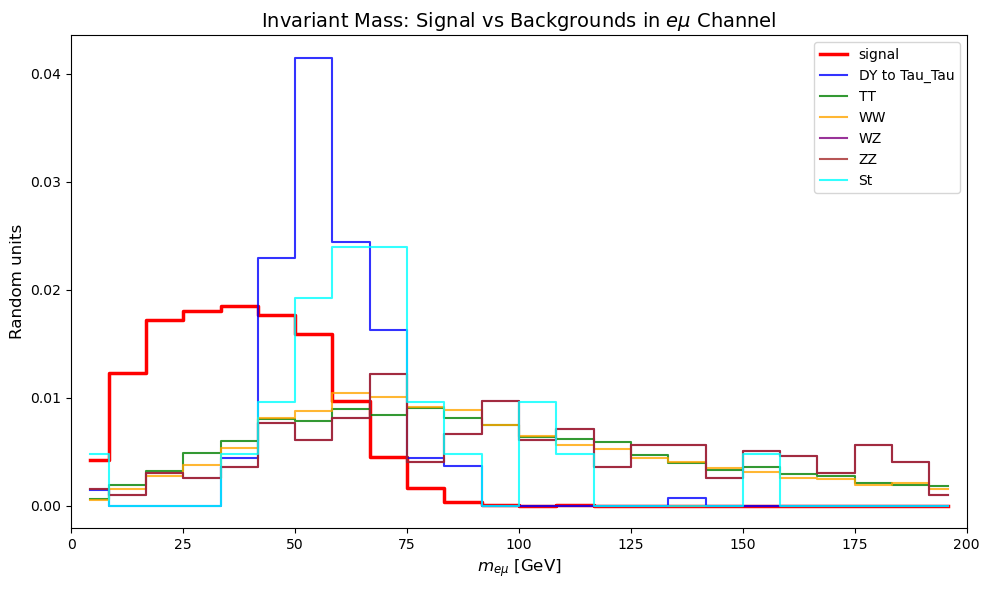

In [69]:
plt.figure(figsize=(10, 6))

for label in files.keys():
    if event_variables[label] is not None:
        masses = event_variables[label]['mass']
        masses_np = ak.to_numpy(masses)
        hist, _ = np.histogram(masses_np, bins=mass_bins, density=True)
        bin_centers = (mass_bins[:-1] + mass_bins[1:]) / 2
        
        linewidth = 2.5 if label == 'signal' else 1.5
        alpha = 1.0 if label == 'signal' else 0.8
        plt.step(bin_centers, hist, where="mid", 
                 label=label, color=colors[label], 
                 linewidth=linewidth, alpha=alpha)
        
plt.xlabel(r"$m_{e\mu}$ [GeV]", fontsize=12)
plt.ylabel("Random units", fontsize=12)
plt.title("Invariant Mass: Signal vs Backgrounds in $e\\mu$ Channel", fontsize=14)
plt.legend()
plt.grid(False)
plt.xlim(0, 200)
plt.tight_layout()
plt.show()

### Kinematic Distributions of Selected Leptons (Electrons and Muons)

To check that our event selection is working as intended, we look at the basic **kinematic variables** for the leading electron and muon in $e\mu$ events:

- **$p_T$ (transverse momentum):** momentum in the plane perpendicular to the beam  
- **$\eta$ (pseudorapidity):** related to the polar angle; helps understand detector coverage  
- **$\phi$ (azimuthal angle):** angle in the transverse plane  

**Plotting approach:**

- Distributions are **normalized**, so we compare shapes rather than absolute event counts  
- The **signal (`ggH`)** is highlighted with a **thicker line**  
- Backgrounds are overlaid to allow clear shape comparisons

**Why this matters:**  
These plots help us confirm that our event selection behaves as expected and aligns with detector acceptance and the underlying physics. Any anomalies here could indicate selection issues or unexpected backgrounds.


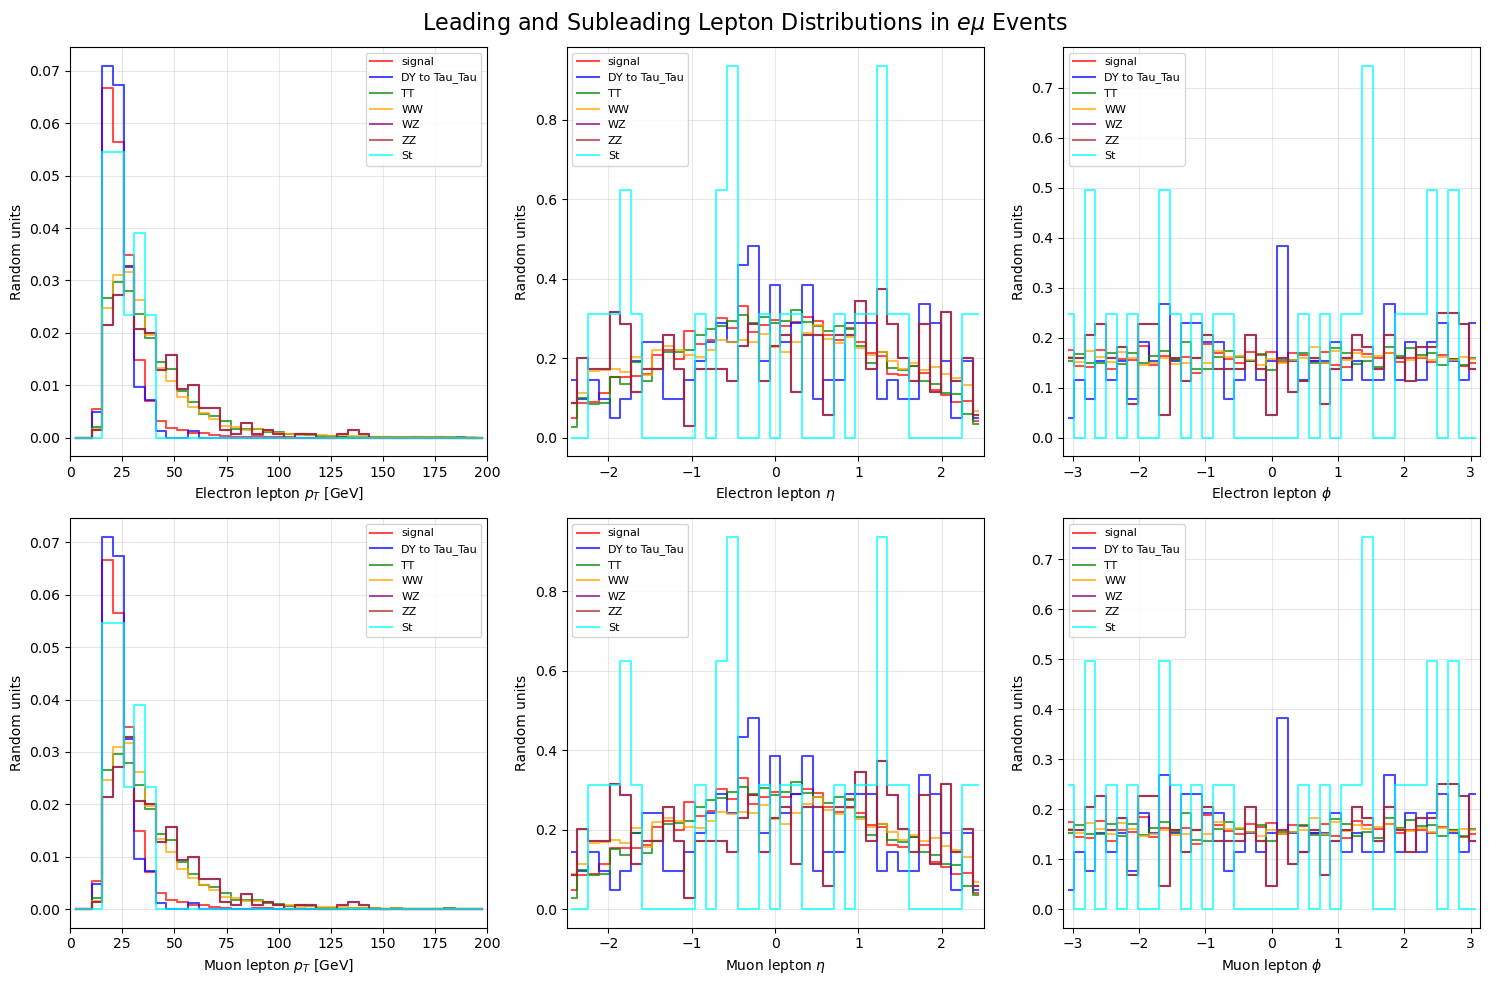

In [86]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Define binning
pt_bins = np.linspace(0, 200, 40)
eta_bins = np.linspace(-2.5, 2.5, 40)
phi_bins = np.linspace(-np.pi, np.pi, 40)

bins_dict = {
    'pt': pt_bins,
    'eta': eta_bins, 
    'phi': phi_bins
}

# Plot for each kinematic variable
variables = ['pt', 'eta', 'phi']
leptons = ['electron', 'muon']

for i, lep_type in enumerate(leptons):
    for j, var in enumerate(variables):
        ax = axes[i, j]
        
        # Plot each sample
        for label in files.keys():
            if label in event_variables and event_variables[label] is not None:
                # Get the appropriate lepton collection
                if lep_type == 'leading':
                    lepton_data = event_variables[label]['leading']
                else:  # subleading
                    lepton_data = event_variables[label]['subleading']
                
                # Get the variable data
                data = getattr(lepton_data, var)
                
                if len(data) > 0:
                    data_np = ak.to_numpy(data)
                    
                    # Create histogram
                    hist, bins = np.histogram(data_np, bins=bins_dict[var], density=True)
                    bin_centers = (bins[:-1] + bins[1:]) / 2
                    
                    # Plot
                    linewidth = 2.5 if label == 'ggH' else 1.5
                    alpha = 1.0 if label == 'ggH' else 0.7
                    ax.step(bin_centers, hist, where='mid', 
                           label=label, color=colors[label], 
                           linewidth=linewidth, alpha=alpha)
        
        # Formatting
        if var == 'pt':
            ax.set_xlabel(f'{lep_type.capitalize()} lepton $p_T$ [GeV]')
            ax.set_xlim(0, 200)
        elif var == 'eta':
            ax.set_xlabel(f'{lep_type.capitalize()} lepton $\\eta$')
            ax.set_xlim(-2.5, 2.5)
        else:
            ax.set_xlabel(f'{lep_type.capitalize()} lepton $\\phi$')
            ax.set_xlim(-np.pi, np.pi)
            
        ax.set_ylabel('Random units')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

plt.suptitle('Leading and Subleading Lepton Distributions in $e\\mu$ Events', fontsize=16)
plt.tight_layout()
plt.show()

### Event-Level Kinematic Distributions

Next, we explore four key observables for the selected $e\mu$ events:

1. **Missing transverse energy ($E_T^{miss}$):** sensitive to neutrinos from $W$ decays  
2. **Azimuthal separation ($\Delta\phi_{e\mu}$):** captures angular correlations between leptons; useful for separating Higgs signal from backgrounds  
3. **Dilepton transverse momentum ($p_T^{e\mu}$):** momentum of the combined eμ system; highlights Higgs recoil effects  
4. **Invariant mass ($m_{e\mu}$):** invariant mass of the eμ pair; provides insight into Higgs kinematics and background shapes  

**Plotting details:**

- Each sample is **normalized to unit area** to focus on distribution shapes  
- The **signal (`ggH`)** is highlighted with a **thicker line**, while backgrounds are overlaid for comparison  

**Why this matters:**  
These plots not only validate our event selection but also reveal subtle differences between the Higgs signal and Standard Model backgrounds, guiding further analysis and potential discriminating variables.


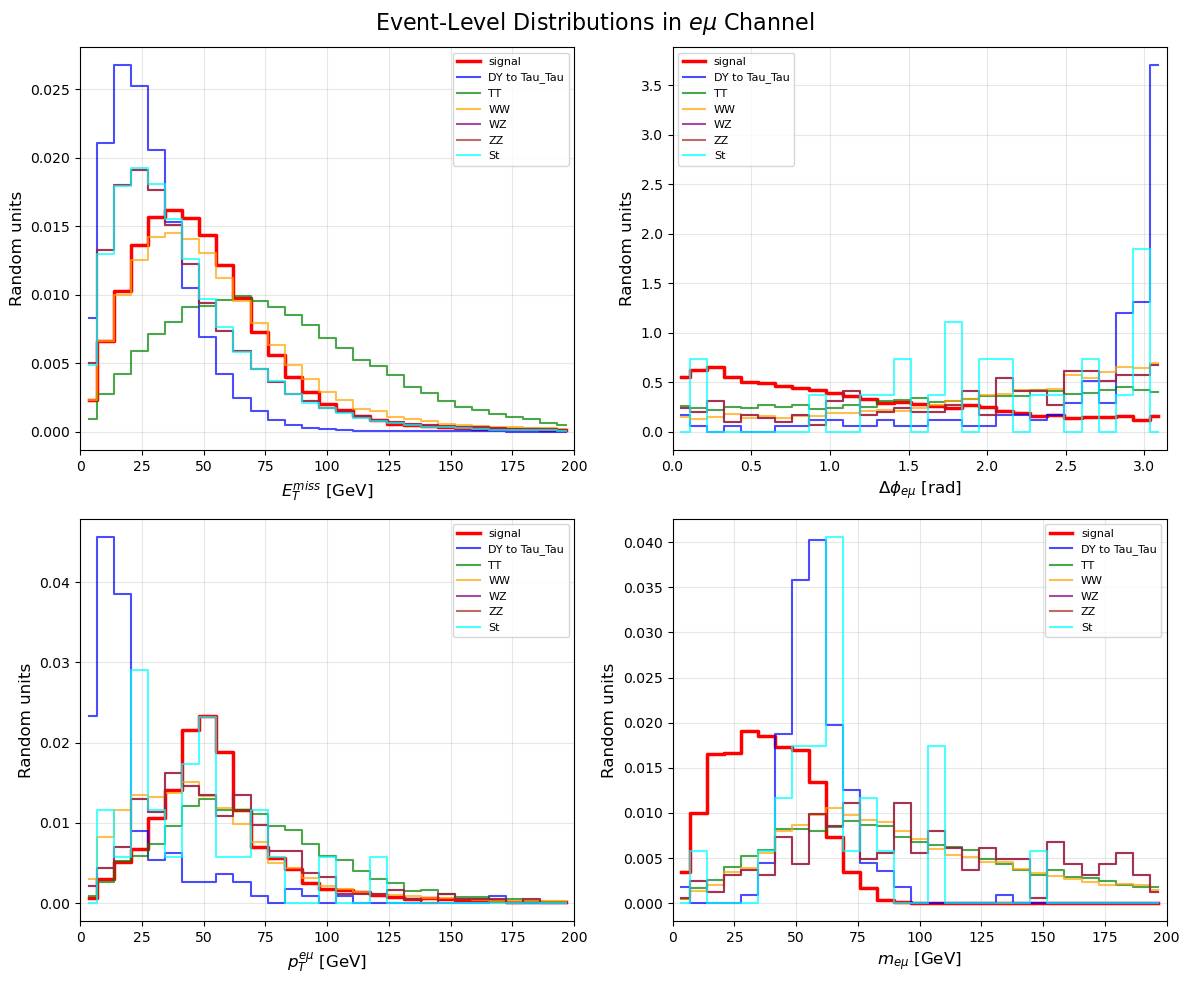

In [75]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

event_vars = {
    'met': {
        'bins': np.linspace(0, 200, 30),
        'xlabel': '$E_T^{miss}$ [GeV]',
        'xlim': (0, 200)
    },
    'dphi': {
        'bins': np.linspace(0, np.pi, 30),
        'xlabel': '$\\Delta\\phi_{e\\mu}$ [rad]',
        'xlim': (0, np.pi)
    },
    'ptll': {
        'bins': np.linspace(0, 200, 30),
        'xlabel': '$p_T^{e\\mu}$ [GeV]',
        'xlim': (0, 200)
    },
    'mass': {
        'bins': np.linspace(0, 200, 30),
        'xlabel': '$m_{e\\mu}$ [GeV]',
        'xlim': (0, 200)
    }
}

for idx, (var_name, var_props) in enumerate(event_vars.items()):
    ax = axes[idx]
    
    for sample in files.keys():
        if event_variables[sample] is not None and var_name in event_variables[sample]:
            data = event_variables[sample][var_name]
            data_np = ak.to_numpy(data)
            
            if len(data_np) > 0:
                # Create histogram
                hist, bins = np.histogram(data_np, bins=var_props['bins'], density=True)
                bin_centers = (bins[:-1] + bins[1:]) / 2
                
                # Plot
                linewidth = 2.5 if sample == 'signal' else 1.5
                alpha = 1.0 if sample == 'signal' else 0.7
                ax.step(bin_centers, hist, where='mid', 
                       label=sample, color=colors[sample], 
                       linewidth=linewidth, alpha=alpha)
    
    ax.set_xlabel(var_props['xlabel'], fontsize=12)
    ax.set_ylabel('Random units', fontsize=12)
    ax.set_xlim(var_props['xlim'])
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

plt.suptitle('Event-Level Distributions in $e\\mu$ Channel', fontsize=16)
plt.tight_layout()
plt.show()


### Summary Statistics of Selected Events

After applying the $e\mu$ selection, we can quickly summarize each dataset with a few key statistics:

- **Number of events:** total events that survive the selection  
- **Mean invariant mass ($m_{e\mu}$):** average mass of the eμ system  
- **Mean missing transverse energy (MET):** average MET from neutrinos  
- **Mean azimuthal separation ($\Delta\phi_{\ell\ell}$):** average angular separation between the electron and muon  
- **Mean dilepton transverse momentum ($p_T^{\ell\ell}$):** average transverse momentum of the eμ system  

These statistics provide a **quick sanity check** and make it easy to compare the **signal** and **background** distributions at a glance, helping us spot any unexpected behavior before moving on to deeper analysis.


In [77]:
print("\n=== Summary Statistics ===\n")
for label in files.keys():
    if event_variables[label] is not None:
        print(f"{label}:")
        print(f"  Number of events: {len(event_variables[label]['mass'])}")
        print(f"  Mean mass: {np.mean(ak.to_numpy(event_variables[label]['mass'])):.2f} GeV")
        print(f"  Mean MET: {np.mean(ak.to_numpy(event_variables[label]['met'])):.2f} GeV")
        print(f"  Mean dphi: {np.mean(ak.to_numpy(event_variables[label]['dphi'])):.3f} rad")
        print(f"  Mean ptll: {np.mean(ak.to_numpy(event_variables[label]['ptll'])):.2f} GeV")
        print()


=== Summary Statistics ===

signal:
  Number of events: 5265
  Mean mass: 37.64 GeV
  Mean MET: 50.07 GeV
  Mean dphi: 1.142 rad
  Mean ptll: 57.44 GeV

DY to Tau_Tau:
  Number of events: 162
  Mean mass: 57.75 GeV
  Mean MET: 28.13 GeV
  Mean dphi: 2.658 rad
  Mean ptll: 20.70 GeV

TT:
  Number of events: 6078
  Mean mass: 109.94 GeV
  Mean MET: 81.87 GeV
  Mean dphi: 1.756 rad
  Mean ptll: 70.06 GeV

WW:
  Number of events: 8507
  Mean mass: 111.98 GeV
  Mean MET: 56.02 GeV
  Mean dphi: 2.051 rad
  Mean ptll: 53.84 GeV

WZ:
  Number of events: 273
  Mean mass: 126.70 GeV
  Mean MET: 43.47 GeV
  Mean dphi: 1.966 rad
  Mean ptll: 61.05 GeV

ZZ:
  Number of events: 273
  Mean mass: 126.70 GeV
  Mean MET: 43.47 GeV
  Mean dphi: 1.966 rad
  Mean ptll: 61.05 GeV

St:
  Number of events: 25
  Mean mass: 69.19 GeV
  Mean MET: 41.56 GeV
  Mean dphi: 2.002 rad
  Mean ptll: 46.93 GeV



### Optional: Stacked Histograms with Signal Overlay

For a more **analysis-style presentation**, we can create **stacked histograms** of background processes with the Higgs signal overlaid:

- **Backgrounds** (`DY`, `TT`, `WW`, `WZ`, `ZZ`, `St`) are stacked  
- **Signal** (`ggH`) is overlaid as a line histogram, optionally scaled for visibility  
- The **y-axis** is set to logarithmic to highlight bins with low statistics  

This type of visualization makes it easy to see the **relative contribution of backgrounds** and identify where the Higgs signal stands out.

> The function `create_stacked_plot(variable_name, var_data, var_props, colors)` can be used for any variable stored in `event_variables`, allowing flexible plotting across different observables.


In [84]:
def create_stacked_plot(variable_name, var_data, var_props, colors):
    """Create stacked histogram with signal on top of backgrounds"""
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    backgrounds = ['DY_Tau_tau', 'TT', 'WW', 'WZ', 'ZZ', 'St']
    signal = 'signal'
    
    # Collect all data including signal
    all_data = []
    all_labels = []
    all_colors = []
    
    # First add backgrounds
    for bkg in backgrounds:
        if bkg in var_data and var_data[bkg] is not None:
            if variable_name in var_data[bkg]:
                data = ak.to_numpy(var_data[bkg][variable_name])
                if len(data) > 0:
                    all_data.append(data)
                    all_labels.append(bkg)
                    all_colors.append(colors[bkg])
    
    # Then add signal on top
    if signal in var_data and var_data[signal] is not None:
        if variable_name in var_data[signal]:
            signal_data = ak.to_numpy(var_data[signal][variable_name])
            if len(signal_data) > 0:
                all_data.append(signal_data)
                all_labels.append(signal)
                all_colors.append(colors[signal])
    
    # Create stacked histogram with signal on top
    if all_data:
        n, bins, patches = ax.hist(all_data, bins=var_props['bins'], 
                                   label=all_labels, color=all_colors,
                                   stacked=True, alpha=0.8, edgecolor='black', 
                                   linewidth=0.5)
    
    ax.set_xlabel(var_props['xlabel'], fontsize=12)
    ax.set_ylabel('Events', fontsize=12)
    ax.set_xlim(var_props['xlim'])
    ax.legend(loc='upper right')
    ax.grid(False)
    
    plt.title(f'Stacked {variable_name.capitalize()} Distribution', fontsize=14)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

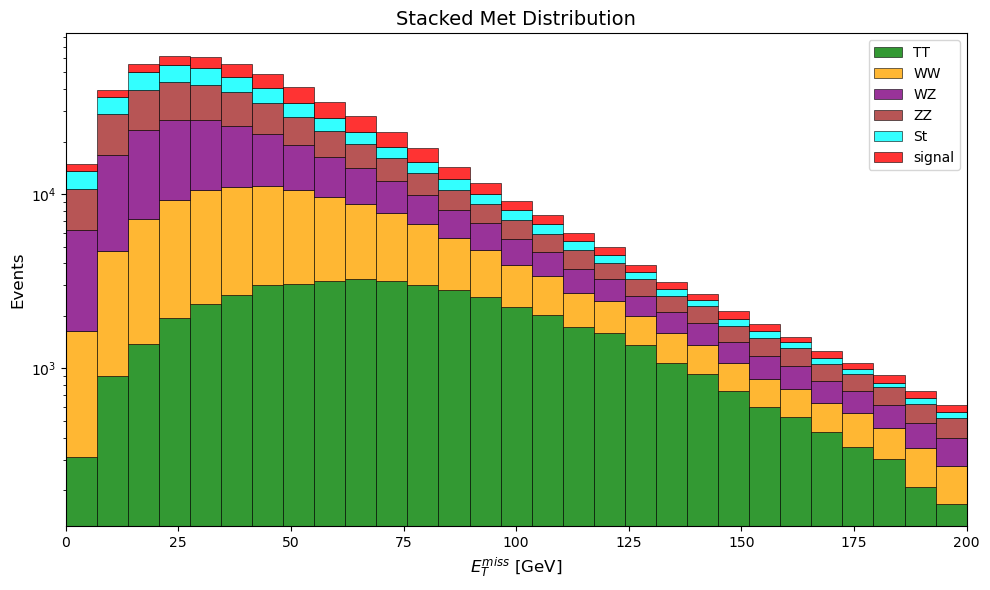

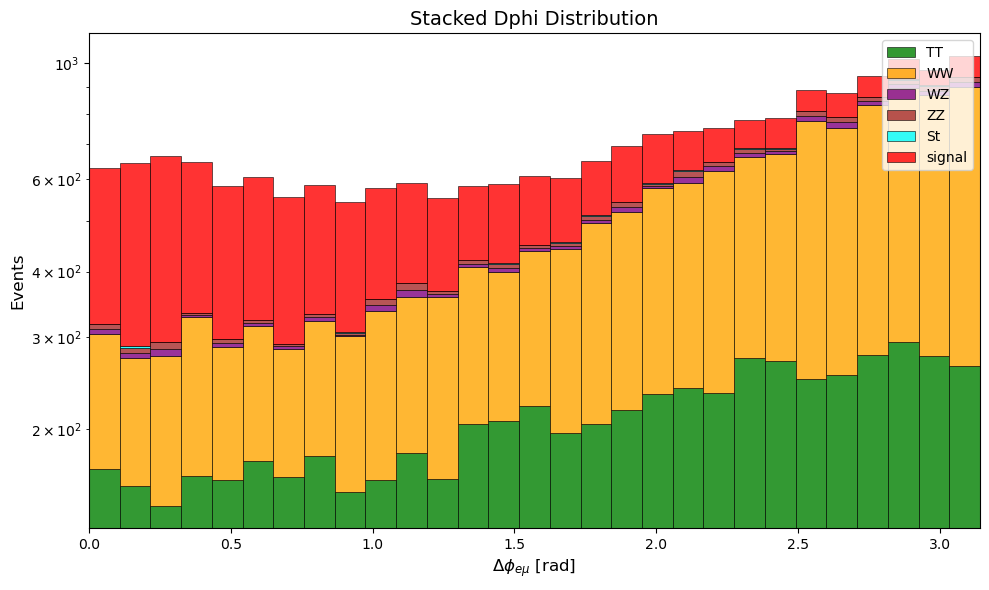

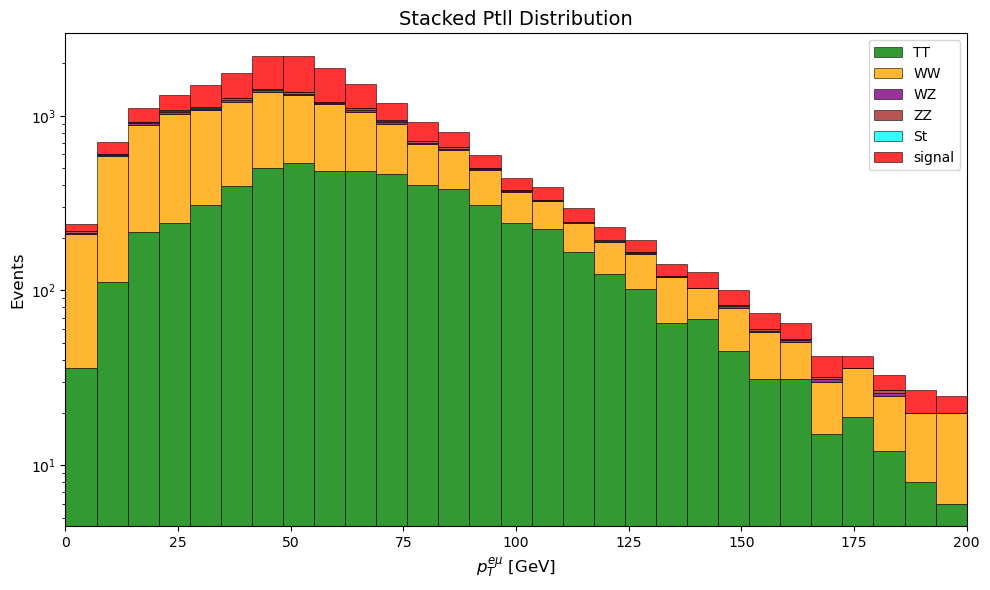

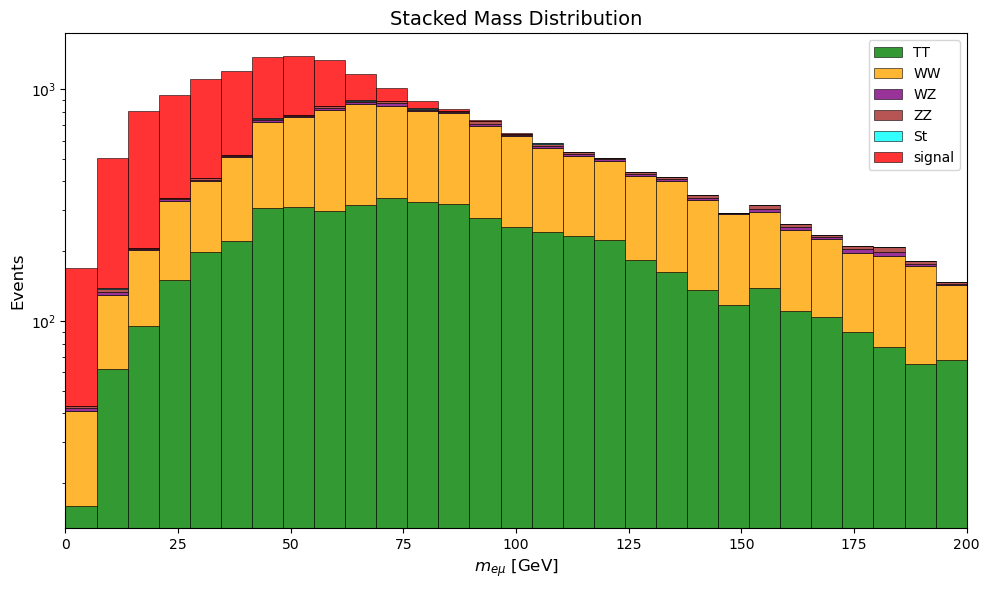

In [85]:
# Create stacked plots for all event variables
for var_name, var_props in event_vars.items():
    create_stacked_plot(var_name, event_variables, var_props, colors)

